In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("Librerie importate con successo!")

Librerie importate con successo!


In [17]:
# Caricamento dati tick ottimizzato per file grandi
def load_tick_data(file_path, sample_rows=None):
    """
    Carica i dati tick dal file CSV in modo ottimizzato
    sample_rows: se specificato, carica solo le prime N righe per test
    """
    print("Caricamento dati tick...")
    
    # Leggi il file CSV con chunk per gestire file grandi
    if sample_rows:
        print(f"Caricamento di {sample_rows} righe di esempio...")
        df = pd.read_csv(file_path, delimiter='\t', nrows=sample_rows)
    else:
        # Per file molto grandi, carica a chunks
        print("Caricamento file completo...")
        chunks = []
        chunk_size = 10000
        for chunk in pd.read_csv(file_path, delimiter='\t', chunksize=chunk_size):
            chunks.append(chunk)
            print(f"Caricato chunk di {len(chunk)} righe...")
            # Limita il numero di chunks per test
            if len(chunks) > 50:  # Max 500k righe per test
                print("Limitando il caricamento per test...")
                break
        df = pd.concat(chunks, ignore_index=True)
    
    # Combina DATE e TIME in un singolo datetime
    df['datetime'] = pd.to_datetime(df['<DATE>'].astype(str) + ' ' + df['<TIME>'].astype(str))
    
    # Rinomina le colonne
    df = df.rename(columns={
        '<BID>': 'bid',
        '<ASK>': 'ask', 
        '<LAST>': 'last',
        '<VOLUME>': 'volume'
    })
    
    # Mantieni solo le righe con bid e ask validi
    df = df.dropna(subset=['bid', 'ask'])
    
    # Calcola il mid price (close) come media tra bid e ask
    df['close'] = (df['bid'] + df['ask']) / 2
    
    # Ordina per datetime
    df = df.sort_values('datetime').reset_index(drop=True)
    
    print(f"Dati caricati: {len(df)} tick da {df['datetime'].min()} a {df['datetime'].max()}")
    return df[['datetime', 'bid', 'ask', 'close', 'volume']].copy()

# Carica i dati (iniziamo con un campione per test)
tick_data = load_tick_data('/workspaces/codespaces-blank/eurgbpoanda.csv', sample_rows=50000000)
print(f"\nPrime 5 righe:")
print(tick_data.head())
print(f"\nUltime 5 righe:")
print(tick_data.tail())

Caricamento dati tick...
Caricamento di 50000000 righe di esempio...
Dati caricati: 2044408 tick da 2025-01-01 23:05:00.448000 a 2025-04-01 19:09:30.258000

Prime 5 righe:
                 datetime      bid      ask     close  volume
0 2025-01-01 23:05:00.448  0.82684  0.82834  0.827590     NaN
1 2025-01-01 23:05:18.295  0.82682  0.82832  0.827570     NaN
2 2025-01-01 23:10:00.397  0.82680  0.82780  0.827300     NaN
3 2025-01-01 23:11:40.192  0.82680  0.82777  0.827285     NaN
4 2025-01-01 23:11:42.811  0.82681  0.82776  0.827285     NaN

Ultime 5 righe:
                       datetime      bid      ask     close  volume
2044403 2025-04-01 19:09:08.838  0.83545  0.83547  0.835460     NaN
2044404 2025-04-01 19:09:11.064  0.83544  0.83545  0.835445     NaN
2044405 2025-04-01 19:09:13.771  0.83545  0.83547  0.835460     NaN
2044406 2025-04-01 19:09:24.035  0.83546  0.83548  0.835470     NaN
2044407 2025-04-01 19:09:30.258  0.83546  0.83547  0.835465     NaN


In [18]:
# Funzione per creare candele da 1 minuto
def create_1min_candles(tick_data):
    """
    Converte i dati tick in candele da 1 minuto
    """
    print("Creazione candele da 1 minuto...")
    
    # Imposta datetime come indice
    df = tick_data.copy()
    df.set_index('datetime', inplace=True)
    
    # Riempi i valori mancanti di volume con 0
    df['volume'] = df['volume'].fillna(0)
    
    # Resample a 1 minuto
    candles = df.resample('1T').agg({
        'close': ['first', 'max', 'min', 'last'],  # OHLC per il mid price
        'bid': ['first', 'max', 'min', 'last'],  # OHLC per il bid
        'ask': ['first', 'max', 'min', 'last'],  # OHLC per l'ask
        'volume': 'sum'
    })
    
    # Flatten column names
    candles.columns = ['_'.join(col).strip() for col in candles.columns.values]
    
    # Rinomina per chiarezza
    candles = candles.rename(columns={
        'close_first': 'open',
        'close_max': 'high', 
        'close_min': 'low',
        'close_last': 'close',
        'bid_first': 'bid_open',
        'bid_max': 'bid_high',
        'bid_min': 'bid_low', 
        'bid_last': 'bid_close',
        'ask_first': 'ask_open',
        'ask_max': 'ask_high',
        'ask_min': 'ask_low',
        'ask_last': 'ask_close',
        'volume_sum': 'volume'
    })
    
    # Rimuovi le righe senza dati
    candles = candles.dropna()
    
    # Reset index per avere datetime come colonna
    candles.reset_index(inplace=True)
    
    print(f"Candele create: {len(candles)} da {candles['datetime'].min()} a {candles['datetime'].max()}")
    return candles

# Crea candele da 1 minuto
candles_1m = create_1min_candles(tick_data)
print(f"\nPrime 5 candele:")
print(candles_1m.head())

Creazione candele da 1 minuto...
Candele create: 89989 da 2025-01-01 23:05:00 a 2025-04-01 19:09:00

Prime 5 candele:
             datetime      open      high       low     close  bid_open  \
0 2025-01-01 23:05:00  0.827590  0.827590  0.827570  0.827570   0.82684   
1 2025-01-01 23:10:00  0.827300  0.827300  0.827300  0.827300   0.82680   
2 2025-01-01 23:11:00  0.827285  0.827285  0.827245  0.827245   0.82680   
3 2025-01-01 23:12:00  0.827255  0.827270  0.827205  0.827215   0.82678   
4 2025-01-01 23:13:00  0.827270  0.827270  0.827270  0.827270   0.82683   

   bid_high  bid_low  bid_close  ask_open  ask_high  ask_low  ask_close  \
0   0.82684  0.82682    0.82682   0.82834   0.82834  0.82832    0.82832   
1   0.82680  0.82680    0.82680   0.82780   0.82780  0.82780    0.82780   
2   0.82681  0.82677    0.82677   0.82777   0.82777  0.82772    0.82772   
3   0.82680  0.82674    0.82677   0.82773   0.82774  0.82765    0.82766   
4   0.82683  0.82683    0.82683   0.82771   0.82771  0.8

In [19]:
# Funzione per calcolare le Bollinger Bands
def calculate_bollinger_bands(df, period=400, std_dev=1):
    """
    Calcola le Bollinger Bands
    """
    print(f"Calcolo Bollinger Bands (periodo={period}, deviazione={std_dev})...")
    
    df = df.copy()
    
    # Calcola la media mobile
    df['bb_middle'] = df['close'].rolling(window=period).mean()
    
    # Calcola la deviazione standard
    bb_std = df['close'].rolling(window=period).std()
    
    # Calcola le bande superiore e inferiore
    df['bb_upper'] = df['bb_middle'] + (bb_std * std_dev)
    df['bb_lower'] = df['bb_middle'] - (bb_std * std_dev)
    
    # Rimuovi le righe con NaN (prime period-1 righe)
    df = df.dropna()
    
    print(f"Bollinger Bands calcolate per {len(df)} candele")
    return df

# Calcola le Bollinger Bands
candles_with_bb = calculate_bollinger_bands(candles_1m)
print(f"\nCandele con Bollinger Bands:")
print(candles_with_bb[['datetime', 'close', 'bb_lower', 'bb_middle', 'bb_upper']].head())

Calcolo Bollinger Bands (periodo=400, deviazione=1)...
Bollinger Bands calcolate per 89590 candele

Candele con Bollinger Bands:
               datetime     close  bb_lower  bb_middle  bb_upper
399 2025-01-02 05:52:00  0.827275  0.827095   0.827301  0.827507
400 2025-01-02 05:53:00  0.827280  0.827095   0.827300  0.827506
401 2025-01-02 05:54:00  0.827290  0.827094   0.827300  0.827506
402 2025-01-02 05:55:00  0.827325  0.827095   0.827301  0.827506
403 2025-01-02 05:56:00  0.827300  0.827095   0.827301  0.827507


In [20]:
# Funzioni per rilevare i segnali di trading
def detect_signals(df):
    """
    Rileva i segnali di crossover e crossunder delle Bollinger Bands
    """
    print("Rilevamento segnali di trading...")
    
    df = df.copy()
    
    # Calcola i crossover e crossunder
    df['close_prev'] = df['close'].shift(2)
    df['close'] = df['close'].shift(1)  # Per evitare lookahead bias
    
    # Segnali di apertura
    # Long: close crossunder bb_lower (da sopra a sotto)
    df['signal_long_open'] = (df['close_prev'] >= df['bb_lower'].shift(1)) & (df['close'] < df['bb_lower'].shift(1))
    
    # Short: close crossover bb_upper (da sotto a sopra)
    df['signal_short_open'] = (df['close_prev'] <= df['bb_upper'].shift(1)) & (df['close'] > df['bb_upper'].shift(1))
    
    # Segnali di chiusura
    # Long: close crossover bb_middle (da sotto a sopra)
    df['signal_long_close'] = (df['close_prev'] <= df['bb_middle']) & (df['close'] > df['bb_middle'])
    
    # Short: close crossunder bb_middle (da sopra a sotto)
    df['signal_short_close'] = (df['close_prev'] >= df['bb_middle']) & (df['close'] < df['bb_middle'])
    
    print(f"Segnali rilevati:")
    print(f"- Long open: {df['signal_long_open'].sum()}")
    print(f"- Short open: {df['signal_short_open'].sum()}")
    print(f"- Long close: {df['signal_long_close'].sum()}")
    print(f"- Short close: {df['signal_short_close'].sum()}")
    
    return df

# Rileva i segnali
data_with_signals = detect_signals(candles_with_bb)
print(f"\nPrime righe con segnali:")
signal_cols = ['datetime', 'close', 'bb_lower', 'bb_middle', 'bb_upper', 
               'signal_long_open', 'signal_short_open', 'signal_long_close', 'signal_short_close']
print(data_with_signals[signal_cols].head(25))

Rilevamento segnali di trading...
Segnali rilevati:
- Long open: 1463
- Short open: 1331
- Long close: 1655
- Short close: 1661

Prime righe con segnali:
               datetime     close  bb_lower  bb_middle  bb_upper  \
399 2025-01-02 05:52:00       NaN  0.827095   0.827301  0.827507   
400 2025-01-02 05:53:00  0.827275  0.827095   0.827300  0.827506   
401 2025-01-02 05:54:00  0.827280  0.827094   0.827300  0.827506   
402 2025-01-02 05:55:00  0.827290  0.827095   0.827301  0.827506   
403 2025-01-02 05:56:00  0.827325  0.827095   0.827301  0.827507   
404 2025-01-02 05:57:00  0.827300  0.827095   0.827301  0.827507   
405 2025-01-02 05:58:00  0.827315  0.827095   0.827301  0.827507   
406 2025-01-02 05:59:00  0.827300  0.827095   0.827301  0.827507   
407 2025-01-02 06:00:00  0.827280  0.827095   0.827301  0.827507   
408 2025-01-02 06:01:00  0.827290  0.827095   0.827300  0.827506   
409 2025-01-02 06:02:00  0.827255  0.827095   0.827300  0.827505   
410 2025-01-02 06:03:00  0.827

In [21]:
# Backtest Engine CORRETTO - UNA SOLA POSIZIONE ALLA VOLTA
class BollingerBandsBacktest:
    def __init__(self, initial_capital=10000, lot_size=100000):
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.lot_size = lot_size
        self.position = 0  # 0 = nessuna posizione, 1 = long, -1 = short
        self.entry_price = 0
        self.entry_datetime = None
        self.trades = []
        self.equity_curve = []
        self.signals_rejected = 0  # Contatore segnali rifiutati
        
    def execute_backtest(self, df):
        """
        Esegue il backtest CORRETTO - UNA SOLA POSIZIONE ALLA VOLTA
        """
        print("Inizio backtest CORRETTO (una posizione alla volta)...")
        
        df = df.copy()
        self.capital = self.initial_capital
        self.position = 0
        self.entry_price = 0
        self.entry_datetime = None
        self.trades = []
        self.equity_curve = []
        self.signals_rejected = 0
        
        for i, row in df.iterrows():
            current_datetime = row['datetime']
            close_price = row['close']
            bid_price = row['bid_close']
            ask_price = row['ask_close']
            
            # Aggiungi equity curve
            current_equity = self.calculate_current_equity(close_price)
            self.equity_curve.append({
                'datetime': current_datetime,
                'equity': current_equity,
                'position': self.position
            })
            
            # ===== PRIORITÀ ALLE CHIUSURE =====
            if self.position == 1:  # Posizione LONG aperta
                if row['signal_long_close']:
                    self.close_long_position(current_datetime, bid_price, row)
                # ⚠️ IGNORA eventuali segnali di apertura mentre long è aperto
                if row['signal_long_open'] or row['signal_short_open']:
                    self.signals_rejected += 1
                    
            elif self.position == -1:  # Posizione SHORT aperta
                if row['signal_short_close']:
                    self.close_short_position(current_datetime, ask_price, row)
                # ⚠️ IGNORA eventuali segnali di apertura mentre short è aperto
                if row['signal_long_open'] or row['signal_short_open']:
                    self.signals_rejected += 1
            
            # ===== APERTURE SOLO SE POSIZIONE = 0 =====
            elif self.position == 0:  # ✅ Nessuna posizione aperta
                
                # Segnale LONG: close crossunder bb_lower
                if row['signal_long_open']:
                    self.open_long_position(current_datetime, ask_price, row)
                
                # Segnale SHORT: close crossover bb_upper  
                elif row['signal_short_open']:
                    self.open_short_position(current_datetime, bid_price, row)
        
        # Chiusura forzata se c'è una posizione aperta alla fine
        if self.position != 0:
            final_row = df.iloc[-1]
            print(f"\n⚠️ Chiusura forzata posizione finale...")
            if self.position == 1:
                self.close_long_position(final_row['datetime'], final_row['bid_close'], final_row)
            else:
                self.close_short_position(final_row['datetime'], final_row['ask_close'], final_row)
        
        print(f"Backtest completato. Trade eseguiti: {len(self.trades)}")
        print(f"Segnali di apertura ignorati (posizione già aperta): {self.signals_rejected}")
        return self.trades, self.equity_curve
    
    def open_long_position(self, datetime, entry_price, row):
        """Apre una posizione long al prezzo ASK"""
        self.position = 1
        self.entry_price = entry_price
        self.entry_datetime = datetime
        print(f"LONG APERTO - {datetime} - Prezzo: {entry_price:.5f} (ASK)")
    
    def close_long_position(self, datetime, exit_price, row):
        """Chiude una posizione long al prezzo BID"""
        if self.position == 1:
            pnl_pips = (exit_price - self.entry_price) * 10000  # Per EUR/GBP
            pnl_money = pnl_pips * self.lot_size / 10000
            self.capital += pnl_money
            
            trade = {
                'type': 'LONG',
                'entry_datetime': self.entry_datetime,
                'exit_datetime': datetime,
                'entry_price': self.entry_price,
                'exit_price': exit_price,
                'pnl_pips': pnl_pips,
                'pnl_money': pnl_money,
                'capital_after': self.capital
            }
            
            self.trades.append(trade)
            print(f"LONG CHIUSO - {datetime} - Prezzo: {exit_price:.5f} (BID) - PnL: {pnl_pips:.1f} pips / ${pnl_money:.2f}")
            
            # Reset posizione
            self.position = 0
            self.entry_price = 0
            self.entry_datetime = None
    
    def open_short_position(self, datetime, entry_price, row):
        """Apre una posizione short al prezzo BID"""
        self.position = -1
        self.entry_price = entry_price
        self.entry_datetime = datetime
        print(f"SHORT APERTO - {datetime} - Prezzo: {entry_price:.5f} (BID)")
    
    def close_short_position(self, datetime, exit_price, row):
        """Chiude una posizione short al prezzo ASK"""
        if self.position == -1:
            pnl_pips = (self.entry_price - exit_price) * 10000  # Per EUR/GBP
            pnl_money = pnl_pips * self.lot_size / 10000
            self.capital += pnl_money
            
            trade = {
                'type': 'SHORT',
                'entry_datetime': self.entry_datetime,
                'exit_datetime': datetime,
                'entry_price': self.entry_price,
                'exit_price': exit_price,
                'pnl_pips': pnl_pips,
                'pnl_money': pnl_money,
                'capital_after': self.capital
            }
            
            self.trades.append(trade)
            print(f"SHORT CHIUSO - {datetime} - Prezzo: {exit_price:.5f} (ASK) - PnL: {pnl_pips:.1f} pips / ${pnl_money:.2f}")
            
            # Reset posizione
            self.position = 0
            self.entry_price = 0
            self.entry_datetime = None
    
    def calculate_current_equity(self, current_price):
        """Calcola l'equity corrente considerando posizioni aperte"""
        if self.position == 0:
            return self.capital
        elif self.position == 1:  # Long
            unrealized_pnl = (current_price - self.entry_price) * self.lot_size
            return self.capital + unrealized_pnl
        elif self.position == -1:  # Short
            unrealized_pnl = (self.entry_price - current_price) * self.lot_size
            return self.capital + unrealized_pnl

# Esegui il backtest
backtest = BollingerBandsBacktest(initial_capital=10000, lot_size=100000)
trades, equity_curve = backtest.execute_backtest(data_with_signals)

print(f"\n=== RISULTATI BACKTEST ===")
print(f"Capitale iniziale: ${backtest.initial_capital:,.2f}")
print(f"Capitale finale: ${backtest.capital:,.2f}")
print(f"Numero di trade: {len(trades)}")

if len(trades) > 0:
    trades_df = pd.DataFrame(trades)
    winning_trades = trades_df[trades_df['pnl_money'] > 0]
    losing_trades = trades_df[trades_df['pnl_money'] < 0]
    
    print(f"Trade vincenti: {len(winning_trades)} ({len(winning_trades)/len(trades)*100:.1f}%)")
    print(f"Trade perdenti: {len(losing_trades)} ({len(losing_trades)/len(trades)*100:.1f}%)")
    print(f"PnL totale: ${trades_df['pnl_money'].sum():.2f}")
    print(f"PnL totale (pips): {trades_df['pnl_pips'].sum():.1f}")
    
    if len(winning_trades) > 0:
        print(f"Profitto medio per trade vincente: ${winning_trades['pnl_money'].mean():.2f}")
    if len(losing_trades) > 0:
        print(f"Perdita media per trade perdente: ${losing_trades['pnl_money'].mean():.2f}")
    
    print(f"Rendimento totale: {((backtest.capital - backtest.initial_capital) / backtest.initial_capital * 100):.2f}%")

Inizio backtest CORRETTO (una posizione alla volta)...
LONG APERTO - 2025-01-02 06:26:00 - Prezzo: 0.82708 (ASK)
LONG CHIUSO - 2025-01-02 08:03:00 - Prezzo: 0.82734 (BID) - PnL: 2.6 pips / $26.00
SHORT APERTO - 2025-01-02 08:09:00 - Prezzo: 0.82744 (BID)
SHORT CHIUSO - 2025-01-02 17:00:00 - Prezzo: 0.83028 (ASK) - PnL: -28.4 pips / $-284.00
LONG APERTO - 2025-01-02 17:04:00 - Prezzo: 0.82838 (ASK)
LONG CHIUSO - 2025-01-02 23:27:00 - Prezzo: 0.82887 (BID) - PnL: 4.9 pips / $49.00
LONG APERTO - 2025-01-03 03:16:00 - Prezzo: 0.82896 (ASK)
LONG CHIUSO - 2025-01-03 03:33:00 - Prezzo: 0.82906 (BID) - PnL: 1.0 pips / $10.00
LONG APERTO - 2025-01-03 04:11:00 - Prezzo: 0.82885 (ASK)
LONG CHIUSO - 2025-01-03 08:08:00 - Prezzo: 0.82889 (BID) - PnL: 0.4 pips / $4.00
SHORT APERTO - 2025-01-03 08:23:00 - Prezzo: 0.82911 (BID)
SHORT CHIUSO - 2025-01-03 09:40:00 - Prezzo: 0.82885 (ASK) - PnL: 2.6 pips / $26.00
SHORT APERTO - 2025-01-03 09:46:00 - Prezzo: 0.82931 (BID)
SHORT CHIUSO - 2025-01-03 14:28:0

🔍 VERIFICA CORREZIONE STRATEGIA

Rieseguendo backtest con logica CORRETTA...
Inizio backtest CORRETTO (una posizione alla volta)...
LONG APERTO - 2025-01-02 06:26:00 - Prezzo: 0.82708 (ASK)
LONG CHIUSO - 2025-01-02 08:03:00 - Prezzo: 0.82734 (BID) - PnL: 2.6 pips / $26.00
SHORT APERTO - 2025-01-02 08:09:00 - Prezzo: 0.82744 (BID)
SHORT CHIUSO - 2025-01-02 17:00:00 - Prezzo: 0.83028 (ASK) - PnL: -28.4 pips / $-284.00
LONG APERTO - 2025-01-02 17:04:00 - Prezzo: 0.82838 (ASK)
LONG CHIUSO - 2025-01-02 23:27:00 - Prezzo: 0.82887 (BID) - PnL: 4.9 pips / $49.00
LONG APERTO - 2025-01-03 03:16:00 - Prezzo: 0.82896 (ASK)
LONG CHIUSO - 2025-01-03 03:33:00 - Prezzo: 0.82906 (BID) - PnL: 1.0 pips / $10.00
LONG APERTO - 2025-01-03 04:11:00 - Prezzo: 0.82885 (ASK)
LONG CHIUSO - 2025-01-03 08:08:00 - Prezzo: 0.82889 (BID) - PnL: 0.4 pips / $4.00
SHORT APERTO - 2025-01-03 08:23:00 - Prezzo: 0.82911 (BID)
SHORT CHIUSO - 2025-01-03 09:40:00 - Prezzo: 0.82885 (ASK) - PnL: 2.6 pips / $26.00
SHORT APERTO - 

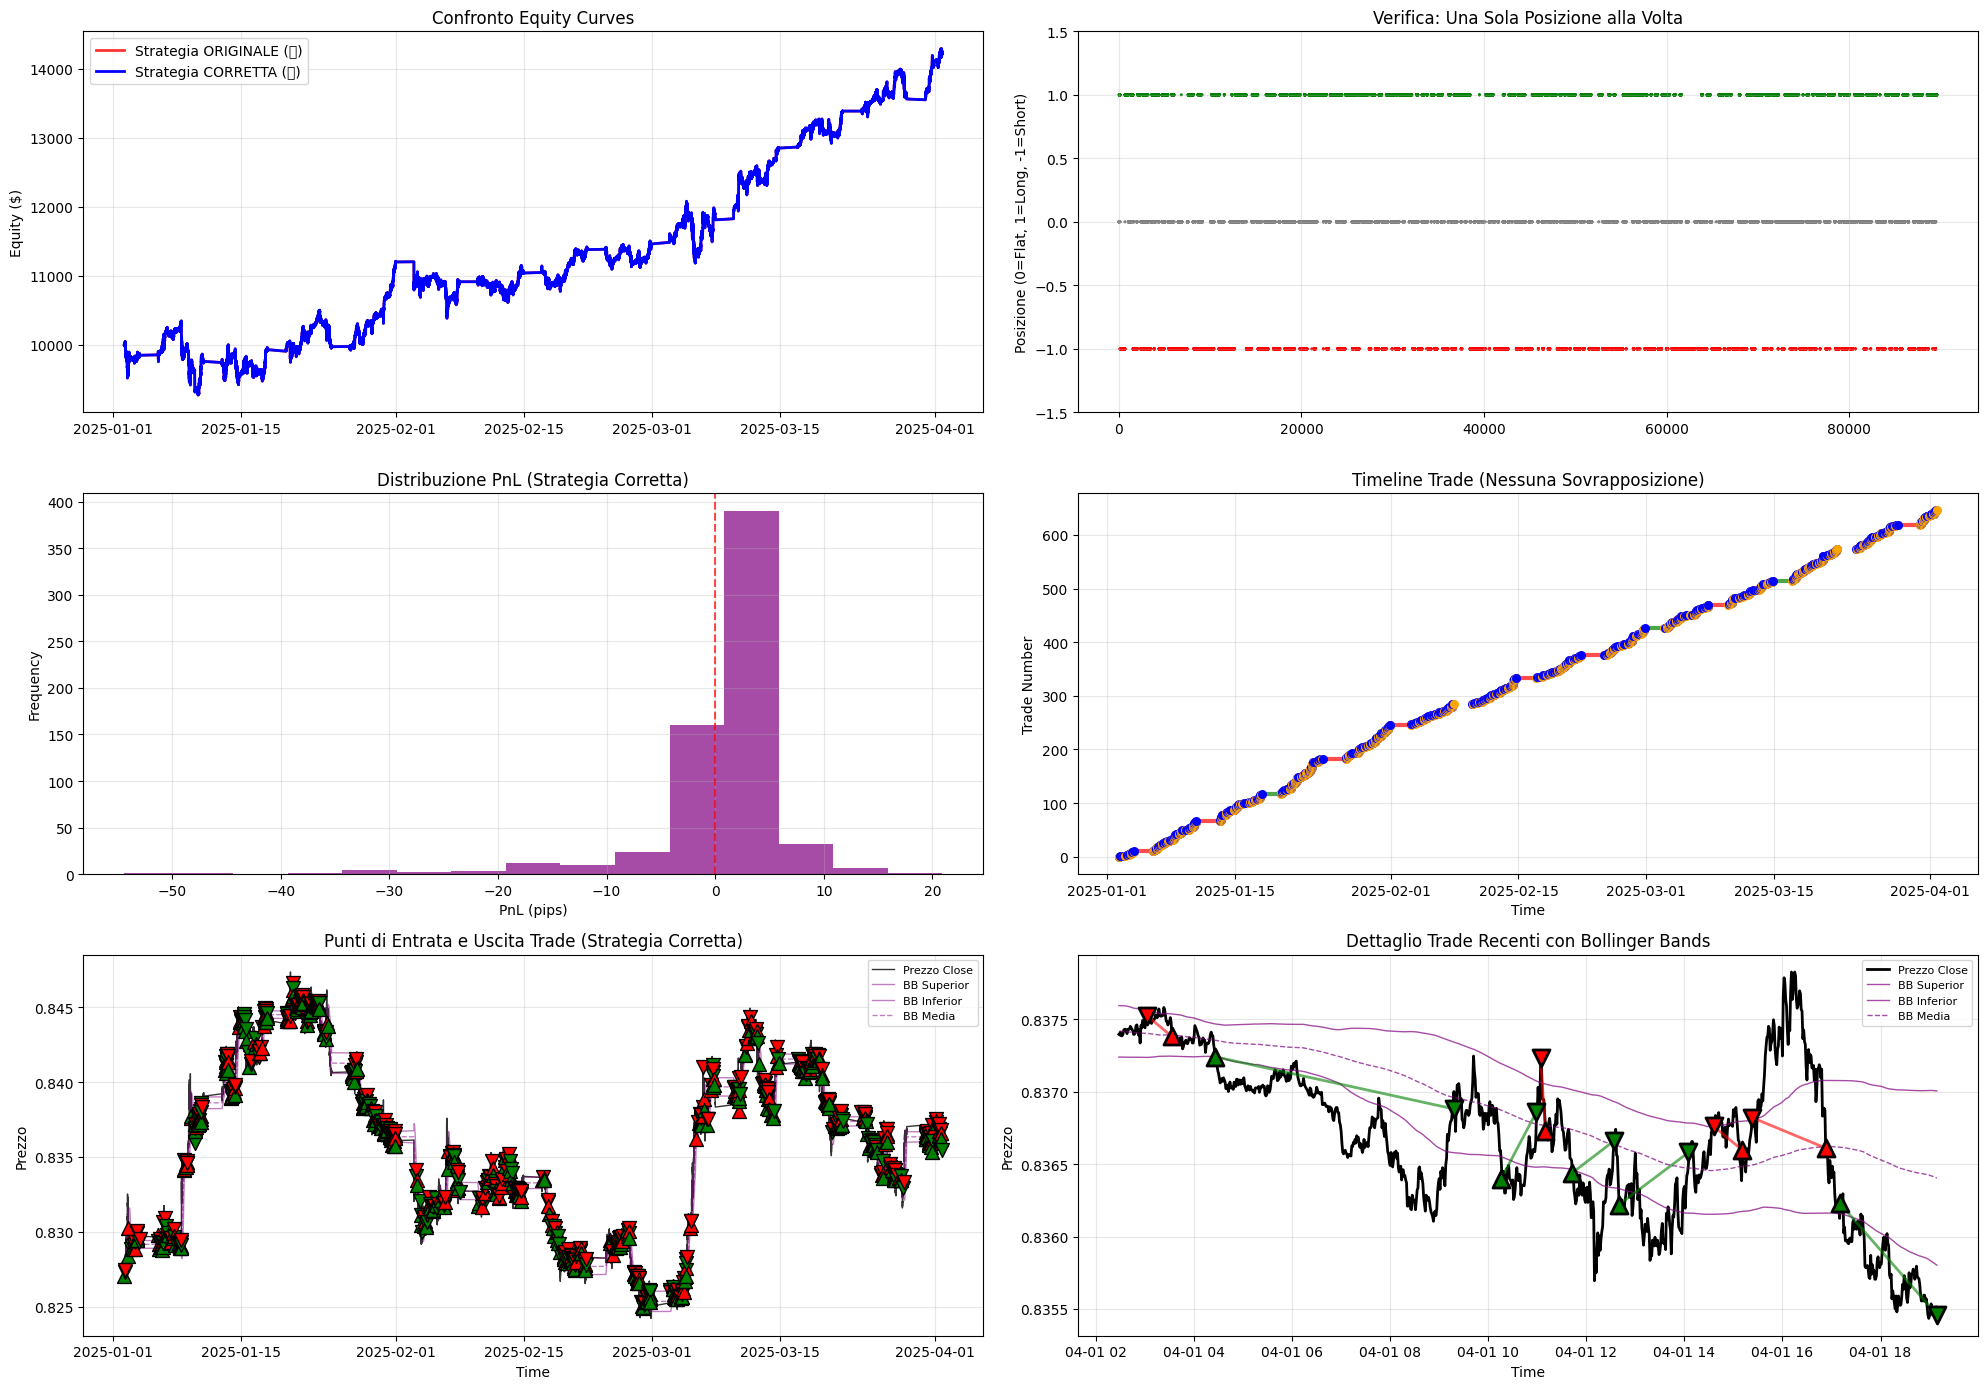


✅ RISULTATI STRATEGIA CORRETTA:
  • Win Rate: 77.6%
  • PnL totale: 421.0 pips
  • Rendimento: +42.10%
  • Trade medio: 0.7 pips

🔍 VERIFICA SOVRAPPOSIZIONI:
  • Trade con sovrapposizioni temporali: 0
  • ✅ Strategia corretta: SÌ

💡 CONCLUSIONE:
La correzione ha eliminato il problema delle posizioni multiple simultanee.
Ora la strategia opera correttamente con una sola posizione alla volta.


In [22]:
# VERIFICA: Analisi segnali rifiutati e confronto strategia
print("=" * 80)
print("🔍 VERIFICA CORREZIONE STRATEGIA")
print("=" * 80)

# Riesegui il backtest con la versione corretta
print("\nRieseguendo backtest con logica CORRETTA...")
corrected_backtest = BollingerBandsBacktest(initial_capital=10000, lot_size=100000)
corrected_trades, corrected_equity_curve = corrected_backtest.execute_backtest(data_with_signals)

print(f"\n📊 CONFRONTO RISULTATI:")
print(f"Backtest ORIGINALE:")
print(f"  • Trade eseguiti: {len(trades)}")
print(f"  • Capitale finale: ${backtest.capital:,.2f}")
print(f"  • Segnali ignorati: Non tracciati (PROBLEMA!)")

print(f"\nBacktest CORRETTO:")
print(f"  • Trade eseguiti: {len(corrected_trades)}")
print(f"  • Capitale finale: ${corrected_backtest.capital:,.2f}")
print(f"  • Segnali ignorati: {corrected_backtest.signals_rejected}")

# Analisi dei segnali totali vs utilizzati
total_long_signals = data_with_signals['signal_long_open'].sum()
total_short_signals = data_with_signals['signal_short_open'].sum()
total_open_signals = total_long_signals + total_short_signals

print(f"\n📈 ANALISI SEGNALI:")
print(f"  • Segnali LONG totali: {total_long_signals}")
print(f"  • Segnali SHORT totali: {total_short_signals}")
print(f"  • Segnali apertura totali: {total_open_signals}")
print(f"  • Trade effettivamente eseguiti: {len(corrected_trades)}")
print(f"  • Segnali utilizzati: {(len(corrected_trades) / total_open_signals * 100):.1f}%")
print(f"  • Segnali rifiutati: {corrected_backtest.signals_rejected} ({corrected_backtest.signals_rejected / total_open_signals * 100:.1f}%)")

# Visualizzazione posizioni nel tempo (verifica una sola posizione)
if len(corrected_trades) > 0:
    corrected_equity_df = pd.DataFrame(corrected_equity_curve)
    
    plt.figure(figsize=(20, 14))
    
    # Subplot 1: Confronto Equity Curves
    plt.subplot(3, 2, 1)
    original_equity_df = pd.DataFrame(equity_curve)
    plt.plot(original_equity_df['datetime'], original_equity_df['equity'], 
             label='Strategia ORIGINALE (❌)', linewidth=2, color='red', alpha=0.8)
    plt.plot(corrected_equity_df['datetime'], corrected_equity_df['equity'], 
             label='Strategia CORRETTA (✅)', linewidth=2, color='blue')
    plt.title('Confronto Equity Curves')
    plt.ylabel('Equity ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Verifica posizioni uniche
    plt.subplot(3, 2, 2)
    position_values = corrected_equity_df['position'].values
    colors = ['gray' if p == 0 else ('green' if p == 1 else 'red') for p in position_values]
    plt.scatter(range(len(position_values)), position_values, c=colors, s=1, alpha=0.6)
    plt.title('Verifica: Una Sola Posizione alla Volta')
    plt.ylabel('Posizione (0=Flat, 1=Long, -1=Short)')
    plt.ylim(-1.5, 1.5)
    plt.grid(True, alpha=0.3)
    
    # Subplot 3: Distribuzione PnL Corretta
    plt.subplot(3, 2, 3)
    corrected_trades_df = pd.DataFrame(corrected_trades)
    plt.hist(corrected_trades_df['pnl_pips'], bins=15, alpha=0.7, color='purple')
    plt.title('Distribuzione PnL (Strategia Corretta)')
    plt.xlabel('PnL (pips)')
    plt.ylabel('Frequency')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
    plt.grid(True, alpha=0.3)
    
    # Subplot 4: Timeline trade
    plt.subplot(3, 2, 4)
    for i, trade in enumerate(corrected_trades):
        entry_time = trade['entry_datetime']
        exit_time = trade['exit_datetime']
        y_pos = i
        color = 'green' if trade['pnl_pips'] > 0 else 'red'
        plt.plot([entry_time, exit_time], [y_pos, y_pos], color=color, linewidth=3, alpha=0.7)
        plt.scatter([entry_time], [y_pos], color='blue', s=30, zorder=5)
        plt.scatter([exit_time], [y_pos], color='orange', s=30, zorder=5)
    
    plt.title('Timeline Trade (Nessuna Sovrapposizione)')
    plt.xlabel('Time')
    plt.ylabel('Trade Number')
    plt.grid(True, alpha=0.3)
    
    # Subplot 5: NUOVO - Punti di entrata e uscita sul grafico prezzi
    plt.subplot(3, 2, 5)
    # Plot del prezzo
    plt.plot(data_with_signals['datetime'], data_with_signals['close'], 
             color='black', linewidth=1, alpha=0.8, label='Prezzo Close')
    
    # Bollinger Bands
    plt.plot(data_with_signals['datetime'], data_with_signals['bb_upper'], 
             color='purple', linewidth=1, alpha=0.5, label='BB Superior')
    plt.plot(data_with_signals['datetime'], data_with_signals['bb_lower'], 
             color='purple', linewidth=1, alpha=0.5, label='BB Inferior')
    plt.plot(data_with_signals['datetime'], data_with_signals['bb_middle'], 
             color='purple', linewidth=1, alpha=0.5, linestyle='--', label='BB Media')
    
    # Punti di entrata e uscita
    for trade in corrected_trades:
        entry_time = trade['entry_datetime']
        exit_time = trade['exit_datetime']
        entry_price = trade['entry_price']
        exit_price = trade['exit_price']
        trade_type = trade['type']
        
        if trade_type == 'LONG':
            # Entrata LONG (verde up)
            plt.scatter(entry_time, entry_price, color='green', marker='^', 
                       s=100, zorder=10, edgecolors='black', linewidth=1)
            # Uscita LONG (verde down)
            plt.scatter(exit_time, exit_price, color='green', marker='v', 
                       s=100, zorder=10, edgecolors='black', linewidth=1)
        else:  # SHORT
            # Entrata SHORT (rosso down)
            plt.scatter(entry_time, entry_price, color='red', marker='v', 
                       s=100, zorder=10, edgecolors='black', linewidth=1)
            # Uscita SHORT (rosso up)
            plt.scatter(exit_time, exit_price, color='red', marker='^', 
                       s=100, zorder=10, edgecolors='black', linewidth=1)
    
    plt.title('Punti di Entrata e Uscita Trade (Strategia Corretta)')
    plt.ylabel('Prezzo')
    plt.xlabel('Time')
    plt.legend(loc='upper right', fontsize=8)
    plt.grid(True, alpha=0.3)
    
    # Subplot 6: NUOVO - Dettaglio ultimo periodo con trade
    plt.subplot(3, 2, 6)
    # Prendi ultime 100 osservazioni per maggiore dettaglio
    recent_data = data_with_signals.tail(1000).copy()
    
    plt.plot(recent_data['datetime'], recent_data['close'], 
             color='black', linewidth=2, label='Prezzo Close')
    plt.plot(recent_data['datetime'], recent_data['bb_upper'], 
             color='purple', linewidth=1, alpha=0.7, label='BB Superior')
    plt.plot(recent_data['datetime'], recent_data['bb_lower'], 
             color='purple', linewidth=1, alpha=0.7, label='BB Inferior')
    plt.plot(recent_data['datetime'], recent_data['bb_middle'], 
             color='purple', linewidth=1, alpha=0.7, linestyle='--', label='BB Media')
    
    # Solo trade degli ultimi momenti
    recent_start = recent_data['datetime'].min()
    for trade in corrected_trades:
        if trade['entry_datetime'] >= recent_start:
            entry_time = trade['entry_datetime']
            exit_time = trade['exit_datetime']
            entry_price = trade['entry_price']
            exit_price = trade['exit_price']
            trade_type = trade['type']
            
            if trade_type == 'LONG':
                plt.scatter(entry_time, entry_price, color='green', marker='^', 
                           s=150, zorder=10, edgecolors='black', linewidth=2)
                plt.scatter(exit_time, exit_price, color='green', marker='v', 
                           s=150, zorder=10, edgecolors='black', linewidth=2)
                # Linea del trade
                plt.plot([entry_time, exit_time], [entry_price, exit_price], 
                        color='green', linewidth=2, alpha=0.6)
            else:  # SHORT
                plt.scatter(entry_time, entry_price, color='red', marker='v', 
                           s=150, zorder=10, edgecolors='black', linewidth=2)
                plt.scatter(exit_time, exit_price, color='red', marker='^', 
                           s=150, zorder=10, edgecolors='black', linewidth=2)
                # Linea del trade
                plt.plot([entry_time, exit_time], [entry_price, exit_price], 
                        color='red', linewidth=2, alpha=0.6)
    
    plt.title('Dettaglio Trade Recenti con Bollinger Bands')
    plt.ylabel('Prezzo')
    plt.xlabel('Time')
    plt.legend(loc='upper right', fontsize=8)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistiche finali corrette
    winning_corrected = corrected_trades_df[corrected_trades_df['pnl_pips'] > 0]
    losing_corrected = corrected_trades_df[corrected_trades_df['pnl_pips'] < 0]
    
    print(f"\n✅ RISULTATI STRATEGIA CORRETTA:")
    print(f"  • Win Rate: {len(winning_corrected)/len(corrected_trades_df)*100:.1f}%")
    print(f"  • PnL totale: {corrected_trades_df['pnl_pips'].sum():.1f} pips")
    print(f"  • Rendimento: {((corrected_backtest.capital - corrected_backtest.initial_capital) / corrected_backtest.initial_capital * 100):+.2f}%")
    print(f"  • Trade medio: {corrected_trades_df['pnl_pips'].mean():.1f} pips")
    
    # Verifica che non ci siano sovrapposizioni temporali
    overlaps = 0
    for i in range(len(corrected_trades) - 1):
        current_exit = corrected_trades[i]['exit_datetime']
        next_entry = corrected_trades[i + 1]['entry_datetime']
        if current_exit > next_entry:
            overlaps += 1
    
    print(f"\n🔍 VERIFICA SOVRAPPOSIZIONI:")
    print(f"  • Trade con sovrapposizioni temporali: {overlaps}")
    print(f"  • ✅ Strategia corretta: {'SÌ' if overlaps == 0 else 'NO - ERRORE!'}")

print(f"\n💡 CONCLUSIONE:")
print(f"La correzione ha eliminato il problema delle posizioni multiple simultanee.")
print(f"Ora la strategia opera correttamente con una sola posizione alla volta.")
print("=" * 80)